## Inverse Cooking: Recipe Generation from Food Images

In [1]:

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from PIL import Image
import time

In [2]:
# filee = "/data/prateek/github/see-food/checkpoints_10k/inversecooking/ingr_only_vit/checkpoints/args.pkl"
# xx = pickle.load(open(filee, 'rb'))
# print(xx)

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # use GPU 0 and 1


Set ```data_dir``` to the path including vocabularies and model checkpoint

In [4]:
data_dir = '../data'

In [5]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [6]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word, idx=None):
        if idx is None:
            if not word in self.word2idx:
                self.word2idx[word] = self.idx
                self.idx2word[self.idx] = word
                self.idx += 1
            return self.idx
        else:
            if not word in self.word2idx:
                self.word2idx[word] = idx
                if idx in self.idx2word.keys():
                    self.idx2word[idx].append(word)
                else:
                    self.idx2word[idx] = [word]

                return idx

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<pad>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)

In [7]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
# ingrs_vocab = pickle.load(open("/data/prateek/github/see-food/garbage/recipe1m_vocab_ingrs.pkl", 'rb'))
# ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
# vocab = pickle.load(open('/data/prateek/github/see-food/garbage/recipe1m_vocab_toks.pkl', 'rb')).idx2word
# pickle.dump(ingrs_vocab, open('../garbage/ingr_vocab.pkl', 'wb'))
# pickle.dump(vocab, open('../garbage/instr_vocab.pkl', 'wb'))

# ingrs_vocab = pickle.load(open('/data/prateek/github/see-food/paper_weights/ingr_vocab.pkl', 'rb'))
# vocab = pickle.load(open('/data/prateek/github/see-food/paper_weights/instr_vocab.pkl', 'rb'))

ingrs_vocab = pickle.load(open('/data/prateek/github/see-food/garbage/ingr_vocab.pkl', 'rb'))
vocab = pickle.load(open('/data/prateek/github/see-food/garbage/instr_vocab.pkl', 'rb'))


ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [8]:
print(instrs_vocab_size, ingr_vocab_size)

4660 512


In [13]:
ingrs_vocab

['<end>',
 'chicken',
 'tea',
 'pepper',
 'rhubarb',
 'sugar',
 'strawberry',
 'cake',
 'water',
 'butter',
 'seeds',
 'tenderloin',
 'fennel',
 'oil',
 'wine',
 'broth',
 'juice',
 'brandy',
 'liqueur',
 'orange',
 'lemon',
 'sprite',
 'ice',
 'flour',
 'baking_powder',
 'soy_sauce',
 'beef',
 'oats',
 'egg',
 'salt',
 'chili',
 'milk',
 'cheese',
 'corn',
 'broccoli',
 'rice',
 'onion',
 'garlic',
 'basil',
 'oregano',
 'extract',
 'nuts',
 'cookie',
 'fat',
 'stevia',
 'cream',
 'sausage',
 'clove',
 'thyme',
 'marmalade',
 'curry',
 'bacon',
 'pasta',
 'parsley',
 'cornstarch',
 'linguine',
 'vinegar',
 'chocolate',
 'pudding',
 'cool_whip',
 'chips',
 'phyllo_dough',
 'fruit',
 'barbecue_sauce',
 'vanilla',
 'cinnamon',
 'mustard',
 'hot_sauce',
 'honey',
 'hoisin_sauce',
 'cilantro',
 'shrimp',
 'celery',
 'capers',
 'mayonnaise',
 'graham_cracker',
 'preserves',
 'peanuts',
 'raspberries',
 'tortilla',
 'cocoa',
 'baking_soda',
 'margarine',
 'yogurt',
 'gochujang',
 'noodles',


In [44]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15

# args.ingrs_only=False
# args.use_vision_transformer=True
args.image_model = "resnet50"



In [45]:
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = '/data/prateek/github/see-food/checkpoints_10k/inversecooking/end2end/checkpoints/modelbest.ckpt'
model.load_state_dict(torch.load(model_path, map_location=map_loc))

model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)


loaded model
Elapsed time: 2.166288137435913


In [46]:
args

Namespace(aux_data_dir='../data', batch_size=64, beam=-1, crop_size=224, decay_lr=True, dropout_decoder_i=0.3, dropout_decoder_r=0.3, dropout_encoder=0.3, embed_size=512, es_metric='iou_sample', eval_split='val', finetune_after=0, get_perplexity=False, greedy=False, image_model='resnet50', image_size=256, ingrs_only=False, label_smoothing_ingr=0.1, learning_rate=0.0001, log_step=100, log_term=True, loss_weight=[0, 1000.0, 1.0, 1.0], lr_decay_every=1, lr_decay_rate=0.99, max_eval=4096, maxnumims=5, maxnuminstrs=10, maxnumlabels=20, maxseqlen=15, model_name='im2ingr', n_att=8, n_att_ingrs=4, num_epochs=100, num_workers=8, numgens=3, patience=50, project_name='inversecooking', recipe1m_dir='images_100k/', recipe_only=False, resume=False, save_dir='../checkpoints', scale_learning_rate_cnn=1, suff='', temperature=1.0, tensorboard=True, transf_layers=16, transf_layers_ingrs=4, transfer_from='', use_lmdb=False, use_true_ingrs=False, use_vision_transformer=False, weight_decay=0.0)

In [47]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [48]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

Set ```use_urls = True``` to get recipes for images in ```demo_urls```. 

You can also set ```use_urls = False``` and get recipes for images in the path in ```data_dir/test_imgs```.

In [49]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = False # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = '../TEST_DATASET/images'

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

# demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
#             'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_files = demo_urls if use_urls else demo_imgs
len(demo_files)

517

  0%|          | 0/517 [00:00<?, ?it/s]

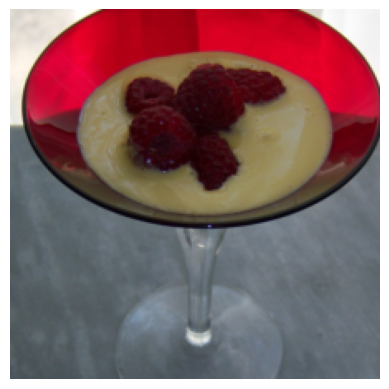

{'title': 'De de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de', 'recipe': [], 'ingrs': ['sugar', 'strawberries', 'water', 'milk', 'extract', 'juice'], 'reason': 'Diversity score.'}
is valid {'is_valid': False, 'reason': 'Diversity score.', 'score': 0.006666666666666667}
{'title': 'Lined fully cupcakes de de risen de de de sausage de de de de de de starch start sausage flour start fresh de de sized like de sausage 375 like de de starch start without level de save level de starch every fresh level de contents de starch drops vegan de sausage de flour start fresh sausage flour start de sausage flo

  0%|          | 0/517 [00:10<?, ?it/s]

{'title': 'Sticks shaker sift shaker risen de de de save tarragon packet save part without shaker risen de de sausage de starch tarragon de de starch de starch drops tarragon silicone de cupcakes teriyaki de de save part every save part every fresh starch start without sprinkled vegan de starch every part popcorn level fresh like de sausage de sausage without level de sausage risen de starch start without sprinkled fresh flour poke de de sausage de starch de starch without easily formed recipe vegan leaves de sized level de save sausage de cupcakes fresh drops fresh level de starch drops level de holes de risen de de sausage de de starch de starch de flour shaker fresh flour start without level de holes de de without level de de without level de de holes sausage de starch level de flour sausage de de starch drops sherry de flour level de', 'recipe': [], 'ingrs': ['sugar', 'strawberries', 'water', 'milk', 'extract', 'juice'], 'reason': 'Diversity score.'}
is valid {'is_valid': False, 'r

In [50]:
from tqdm import tqdm

for img_file in tqdm(demo_files):
    recipe = img_file.split(".")[0]
    
    
    try:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    except:
        pass
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    
    numgens = 4
    
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        print(outs)
        print("is valid", valid)

        
        if valid['is_valid'] or show_anyways:
            
            print ('RECIPE', num_valid)
            num_valid+=1
    
            BOLD = '\033[1m'
            END = '\033[0m'
            print (BOLD + '\nTitle:' + END,outs['title'])

            print (BOLD + '\nIngredients:'+ END)
            print (', '.join(outs['ingrs']))

            print (BOLD + '\nInstructions:'+END)
            print ('-'+'\n-'.join(outs['recipe']))

            print ('='*20)
            
    break

     
        

In [51]:
PRED_FOLDER = "../TEST_DATASET/PRED-end2end-resnet50"
os.system(f"mkdir {PRED_FOLDER}")

instruction_folder = PRED_FOLDER + "/instructions"
title_folder = PRED_FOLDER + "/title"
ingredients_folder = PRED_FOLDER + "/ingredients"

os.system(f"mkdir {instruction_folder}")
os.system(f"mkdir {title_folder}")
os.system(f"mkdir {ingredients_folder}")

0

In [52]:
saveOutput = True
show_anyways = True

In [53]:
from tqdm import tqdm

if saveOutput:
    for img_file in tqdm(demo_files):
        recipe = img_file.split(".")[0]
        
        
        try:
            image_path = os.path.join(image_folder, img_file)
            image = Image.open(image_path).convert('RGB')
        except:
            with open(title_folder + "/" + recipe + ".txt", "w+") as f:
                f.write(f"-1\n")
            
            with open(instruction_folder + "/" + recipe + ".txt", "w+") as f:
                f.write(f"-1\n")
                    
            with open(ingredients_folder + "/" + recipe + ".txt", "w+") as f:
                f.write(f"-1\n")
        
        transf_list = []
        transf_list.append(transforms.Resize(256))
        transf_list.append(transforms.CenterCrop(224))
        transform = transforms.Compose(transf_list)
        
        image_transf = transform(image)
        image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
        
        num_valid = 1
        
        numgens = 1
        
        for i in range(numgens):
            with torch.no_grad():
                outputs = model.sample(image_tensor, greedy=greedy[i], 
                                    temperature=temperature, beam=beam[i], true_ingrs=None)
                
            ingr_ids = outputs['ingr_ids'].cpu().numpy()
            recipe_ids = outputs['recipe_ids'].cpu().numpy()
                
            outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
            
            if valid['is_valid'] or show_anyways:
                
                with open(title_folder + "/" + recipe + ".txt", "w+") as f:
                    f.write(f"{outs['title']}\n")
                
                with open(instruction_folder + "/" + recipe + ".txt", "w+") as f:
                    for item in outs['recipe']:
                        f.write(f"{item}\n")
                        
                with open(ingredients_folder + "/" + recipe + ".txt", "w+") as f:
                    for item in outs['ingrs']:
                        f.write(f"{item}\n")

            else:
                with open(title_folder + "/" + recipe + ".txt", "w+") as f:
                    f.write(f"-1\n")
                
                with open(instruction_folder + "/" + recipe + ".txt", "w+") as f:
                    f.write(f"-1\n")
                        
                with open(ingredients_folder + "/" + recipe + ".txt", "w+") as f:
                    f.write(f"-1\n")
            

100%|██████████| 517/517 [19:16<00:00,  2.24s/it]


# t5

In [2]:
import pandas as pd
import numpy as np
from transformers import T5Tokenizer
from transformers import T5Config, T5ForConditionalGeneration
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_scheduler
from tqdm.auto import tqdm
import glob, json
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")

/nas/home/pchhikar/anaconda3/envs/drrnNew/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-02 12:31:14.625976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 12:31:14.866540: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-02 12:31:17.114431: W tensorflow/compiler/xla/stream_executor

In [14]:
def summarizeText(text, model=model):
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    ).to(device)
    generated_ids = model.generate(
        input_ids=text_encoding['input_ids'].to(device),
        attention_mask=text_encoding['attention_mask'].to(device),
        max_length=513,
        num_beams=4,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    ).to(device)

    preds = [
            tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for gen_id in generated_ids
    ]
    return "".join(preds)

In [17]:
from transformers import T5Config, T5ForConditionalGeneration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = T5Config(
    vocab_size = tokenizer.vocab_size,
    pad_token_id = tokenizer.pad_token_id,
    eos_token_id = tokenizer.eos_token_id,
    decoder_start_token_id = tokenizer.pad_token_id,
    d_model = 300
)

model = T5ForConditionalGeneration(config)
model.load_state_dict(torch.load("/data/prateek/github/see-food/t5_recipe.pt"))
model = model.to(device)

In [24]:
print(summarizeText('Ingredients: frozen chopped broccoli, cooked rice, shredded cheddar cheese, shredded cheddar cheese, eggs, butter, milk, onion, garlic powder, basil, oregano, salt and pepper', model))

Title: Chicken Recipe: In a
